In [476]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nibabel as nib
from torch.utils.data import DataLoader
from tqdm import tqdm

from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from gloss_dminus import GlobalLossDminus
from seg_unet import UNet
import torch.nn.functional as F
from training_utils import double_std, plot_losses

import json
import statistics
from sklearn.metrics import f1_score
import pickle

import scipy.stats as sp

In [477]:
def plot_losses(save_directory):
    
    save_models = save_directory + '/save_models/'
    infile = open(save_directory + '/losses.pkl','rb')
    losses = pickle.load(infile)
    
    losses_min = losses.loc[losses['validation loss'] == losses['validation loss'].min()]

    plt.figure()
    losses.plot(x = 'epoch', y =['train loss','validation loss'],mark_right=False)
    plt.savefig(save_directory + '/loss.png')

    plt.figure()

In [487]:
def plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file, plot_loss = False, last_epoch = False) :
    results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        if last_epoch and pretraining != 'baseline':
                            save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val_pretrainedEpoch1499/run_' + str(run)
                        else : 
                            save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        if plot_loss :
                            plot_losses(save_directory_name)
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        
                        results_BN['batch_size'] = batch_size
                        results = results.append(results_BN)
    
    results_mean = results.groupby([ "n vol train", "batch_size", "model"]).agg([np.mean, double_std, sp.sem])
    #print(results_mean)
    results_test_f1 = results_mean['test F1']
    results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem").get_figure()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig('trained_models/max_epochs/figures/'+ save_file +'.png', bbox_inches='tight')
    return results_test_f1, results


In [479]:
def plot_results_per_label(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file) :
    results = pd.DataFrame(columns = ["F1 label", "label", "n vol train", "batch_size", "model"])
    labels = ['RV', 'Myo', 'LV'] 
    
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        for i,label in enumerate(labels) :
                            results_BN["F1 label"] = results_BN['f1_arr'][0][i]
                            results_BN["label"] = label
                            results=results.append(results_BN)
                            
                        #print(results) 
                        #print(results_BN)
                        #results = results.append(results_BN[["RV F1", 'Myo F1', 'LV F1', "n vol train", "batch_size", "loss unet", "model"]])
    #print(results)
    
    results_mean = results.groupby([ "n vol train", "batch_size", "label", "model"]).agg([np.mean, double_std, sp.sem])
    #print(results_mean)
    results_test_f1 = results_mean['F1 label']
    
        
    
    #print(results_test_f1)
    #results_test_f1 = results_mean[['RV F1', 'Myo F1', 'LV F1']]
    results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem").get_figure()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return results_test_f1, results

In [480]:
def plot_results_per_label_Abide(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file) :
    results = pd.DataFrame(columns = ["F1 label", "label", "n vol train", "batch_size", "model"])
    labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'] 
    
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        for i,label in enumerate(labels) :
                            results_BN["F1 label"] = results_BN['f1_arr'][0][i]
                            results_BN["label"] = label
                            results=results.append(results_BN)
                            
                        #print(results) 
                        #print(results_BN)
                        #results = results.append(results_BN[["RV F1", 'Myo F1', 'LV F1', "n vol train", "batch_size", "loss unet", "model"]])
    #print(results)
    
    results_mean = results.groupby([ "n vol train", "batch_size", "label", "model"]).agg([np.mean, double_std, sp.sem])
    #print(results_mean)
    results_test_f1 = results_mean['F1 label']
    
        
    
    #print(results_test_f1)
    #results_test_f1 = results_mean[['RV F1', 'Myo F1', 'LV F1']]
    results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem").get_figure()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #return results_test_f1, results

In [481]:
import seaborn as sns
def boxplot(ave_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file, plot_loss = False) :
    results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        if plot_loss :
                            plot_losses(save_directory_name)
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        
                        results_BN['batch_size'] = batch_size
                        results = results.append(results_BN)
                        
    #results_mean = results.groupby([ "n vol train", "batch_size", "model"])
    sns.boxplot(x= results["n vol train"], y = results['test F1'], hue = results["model"], #palette = 'husl', 
                showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
    
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    

In [482]:
runs = ['0','1', '2', '3', '4']
n_trains = [1, 2]
losses = ['crossentropy_loss']
lr = 0.001

# Results ACDC (heart)

### Batch size comparaison

mean  double_std       sem
n vol train batch_size model                                   
1           16.0       baseline  0.619208    0.066934  0.016734
            40.0       baseline  0.595565    0.125696  0.031424
            64.0       baseline  0.606843    0.109181  0.027295
2           16.0       baseline  0.727240    0.040772  0.010193
            40.0       baseline  0.734343    0.049990  0.012497
            64.0       baseline  0.711847    0.095159  0.023790

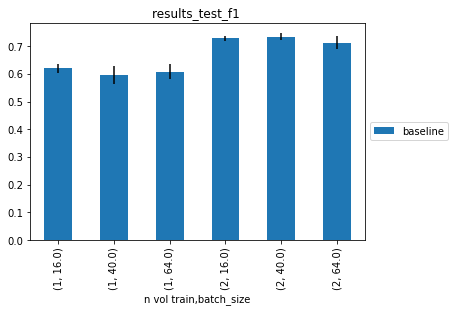

In [446]:
save_directory = './trained_models/ACDC/'
pretrainings = ['baseline']
batch_sizes  = [16, 40, 64 ]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

### Pretrained with ACDC, ACDC fine-tuning

mean  \
n vol train batch_size model                                            
1           16.0       baseline                              0.619208   
                       pretrained with ACDC (global_d)       0.609741   
                       pretrained with ACDC (global_dminus)  0.652235   
            40.0       baseline                              0.595565   
                       pretrained with ACDC (global_d)       0.638003   
                       pretrained with ACDC (global_dminus)  0.648987   
            64.0       baseline                              0.606843   
                       pretrained with ACDC (global_d)       0.602495   
                       pretrained with ACDC (global_dminus)  0.637194   
2           16.0       baseline                              0.727240   
                       pretrained with ACDC (global_d)       0.760977   
                       pretrained with ACDC (global_dminus)  0.743876   
            40.0       baseline                              0.734343   
                       pretrained with ACDC (global_d)       0.741807   
                       pretrained with ACDC (global_dminus)  0.756382   
            64.0       baseline                              0.711847   
                       pretrained with ACDC (global_d)       0.715060   
                       pretrained with ACDC (global_dminus)  0.710362   

                                                             double_std  \
n vol train batch_size model                                              
1           16.0       baseline                                0.066934   
                       pretrained with ACDC (global_d)         0.132596   
                       pretrained with ACDC (global_dminus)    0.083132   
            40.0       baseline                                0.125696   
                       pretrained with ACDC (global_d)         0.045798   
                       pretrained with ACDC (global_dminus)    0.060728   
            64.0       baseline                                0.109181   
                       pretrained with ACDC (global_d)         0.089029   
                       pretrained with ACDC (global_dminus)    0.115638   
2           16.0       baseline                                0.040772   
                       pretrained with ACDC (global_d)         0.029303   
                       pretrained with ACDC (global_dminus)    0.071033   
            40.0       baseline                                0.049990   
                       pretrained with ACDC (global_d)         0.056619   
                       pretrained with ACDC (global_dminus)    0.039271   
            64.0       baseline                                0.095159   
                       pretrained with ACDC (global_d)         0.074054   
                       pretrained with ACDC (global_dminus)    0.053941   

                                                                  sem  
n vol train batch_size model                                           
1           16.0       baseline                              0.016734  
                       pretrained with ACDC (global_d)       0.033149  
                       pretrained with ACDC (global_dminus)  0.020783  
            40.0       baseline                              0.031424  
                       pretrained with ACDC (global_d)       0.011449  
                       pretrained with ACDC (global_dminus)  0.015182  
            64.0       baseline                              0.027295  
                       pretrained with ACDC (global_d)       0.022257  
                       pretrained with ACDC (global_dminus)  0.028910  
2           16.0       baseline                              0.010193  
                       pretrained with ACDC (global_d)       0.007326  
                       pretrained with ACDC (global_dminus)  0.017758  
            40.0       baseline                              0.012497  
                       

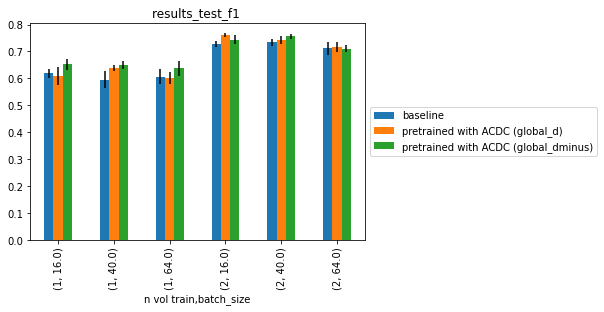

In [447]:
save_directory = './trained_models/ACDC/'
pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)'
               ]

batch_sizes  = [16, 40, 64]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)
results_test_f1

mean  \
n vol train batch_size model                                                          
1           40.0       baseline                                            0.595565   
                       pretrained with ACDC (global_d)                     0.638003   
                       pretrained with ACDC (global_dminus)                0.648987   
                       pretrained with ACDC (representation_loss_globa...  0.643929   
                       pretrained with ACDC (representation_loss_globa...  0.627114   
2           40.0       baseline                                            0.734343   
                       pretrained with ACDC (global_d)                     0.741807   
                       pretrained with ACDC (global_dminus)                0.756382   
                       pretrained with ACDC (representation_loss_globa...  0.755019   
                       pretrained with ACDC (representation_loss_globa...  0.754767   

                                                                           double_std  \
n vol train batch_size model                                                            
1           40.0       baseline                                              0.125696   
                       pretrained with ACDC (global_d)                       0.045798   
                       pretrained with ACDC (global_dminus)                  0.060728   
                       pretrained with ACDC (representation_loss_globa...    0.067291   
                       pretrained with ACDC (representation_loss_globa...    0.104915   
2           40.0       baseline                                              0.049990   
                       pretrained with ACDC (global_d)                       0.056619   
                       pretrained with ACDC (global_dminus)                  0.039271   
                       pretrained with ACDC (representation_loss_globa...    0.058660   
                       pretrained with ACDC (representation_loss_globa...    0.069056   

                                                                                sem  
n vol train batch_size model                                                         
1           40.0       baseline                                            0.031424  
                       pretrained with ACDC (global_d)                     0.011449  
                       pretrained with ACDC (global_dminus)                0.015182  
                       pretrained with ACDC (representation_loss_globa...  0.016823  
                       pretrained with ACDC (representation_loss_globa...  0.026229  
2           40.0       baseline                                            0.012497  
                       pretrained with ACDC (global_d)                     0.014155  
                       pretrained with ACDC (global_dminus)                0.009818  
                       pretrained with ACDC (representation_loss_globa...  0.014665  
                       pretrained with ACDC (representation_loss_globa...  0.017264

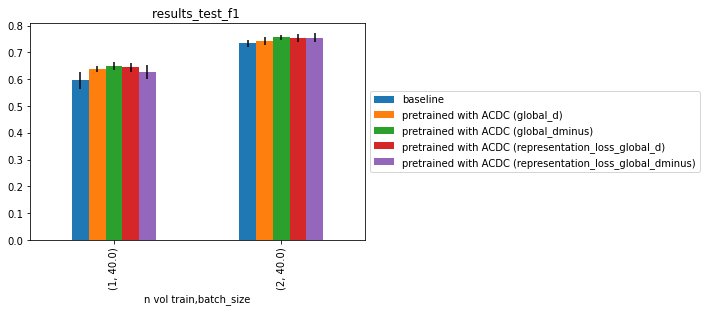

In [448]:
save_directory = './trained_models/ACDC/'

pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)',
                'pretrained with ACDC (representation_loss_global_d)',
                'pretrained with ACDC (representation_loss_global_dminus)',
                
               ]
batch_sizes  = [40]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)
results_test_f1

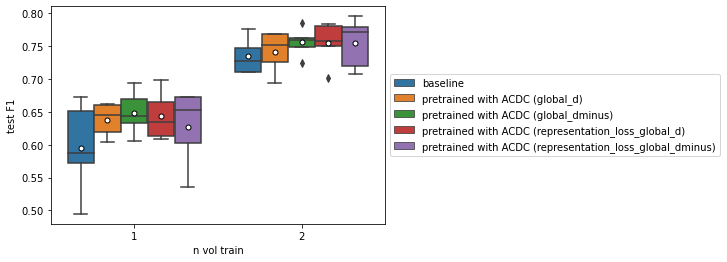

In [449]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

### Pretrained with 4 datasets (HCP, ACDC, Chaos, MedDecat Prostate), ACDC fine-tuning

mean  \
n vol train batch_size model                                                          
1           40.0       baseline                                            0.595565   
                       pretrained with 4 datasets (2 steps global_d)       0.596247   
                       pretrained with 4 datasets (2 steps global_dminus)  0.533845   
                       pretrained with 4 datasets (global_d)               0.609660   
                       pretrained with 4 datasets (global_dminus)          0.566862   
                       pretrained with 4 datasets (representation_loss...  0.615770   
                       pretrained with 4 datasets (representation_loss...  0.633160   
2           40.0       baseline                                            0.734343   
                       pretrained with 4 datasets (2 steps global_d)       0.743991   
                       pretrained with 4 datasets (2 steps global_dminus)  0.732271   
                       pretrained with 4 datasets (global_d)               0.725038   
                       pretrained with 4 datasets (global_dminus)          0.748535   
                       pretrained with 4 datasets (representation_loss...  0.749884   
                       pretrained with 4 datasets (representation_loss...  0.753700   

                                                                           double_std  \
n vol train batch_size model                                                            
1           40.0       baseline                                              0.125696   
                       pretrained with 4 datasets (2 steps global_d)         0.098337   
                       pretrained with 4 datasets (2 steps global_dminus)    0.134647   
                       pretrained with 4 datasets (global_d)                 0.073831   
                       pretrained with 4 datasets (global_dminus)            0.121674   
                       pretrained with 4 datasets (representation_loss...    0.058299   
                       pretrained with 4 datasets (representation_loss...    0.047637   
2           40.0       baseline                                              0.049990   
                       pretrained with 4 datasets (2 steps global_d)         0.015008   
                       pretrained with 4 datasets (2 steps global_dminus)    0.047713   
                       pretrained with 4 datasets (global_d)                 0.019938   
                       pretrained with 4 datasets (global_dminus)            0.046845   
                       pretrained with 4 datasets (representation_loss...    0.047258   
                       pretrained with 4 datasets (representation_loss...    0.053255   

                                                                                sem  
n vol train batch_size model                                                         
1           40.0       baseline                                            0.031424  
                       pretrained with 4 datasets (2 steps global_d)       0.024584  
                       pretrained with 4 datasets (2 steps global_dminus)  0.033662  
                       pretrained with 4 datasets (global_d)               0.018458  
                       pretrained with 4 datasets (global_dminus)          0.030419  
                       pretrained with 4 datasets (representation_loss...  0.014575  
                       pretrained with 4 datasets (representation_loss...  0.011909  
2           40.0       baseline                                            0.012497  
                       pretrained with 4 datasets (2 steps global_d)       0.003752  
                       pretrained with 4 datasets (2 steps global_dminus)  0.011928  
                       pretrained with 4 datasets (global_d)               0.004984  
                       pretrained with 4 datasets (global_dminus)          0.011711  
                       pretrained with 4 datasets (repres

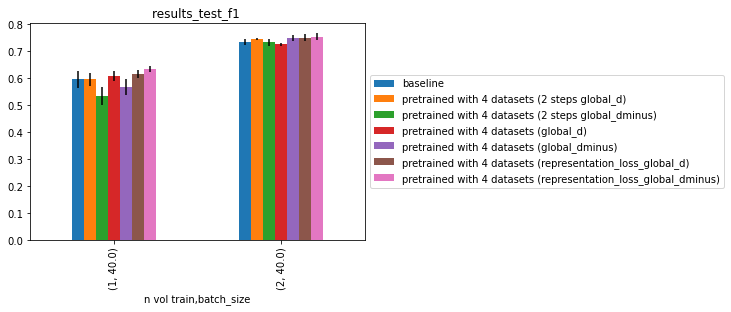

In [450]:
save_directory = './trained_models/ACDC/'
runs = ['0','1', '2', '3', '4']

pretrainings = ['baseline',
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (2 steps global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
                
                
               ]
batch_sizes  = [40]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)
results_test_f1

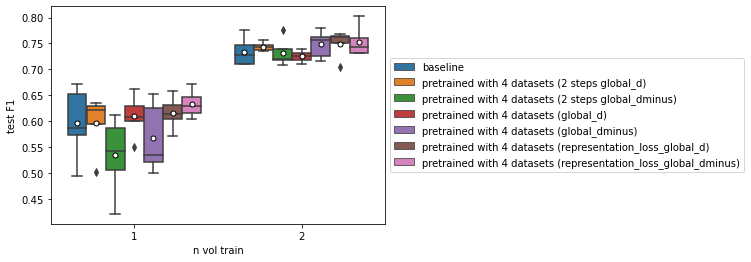

In [451]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

### All together, ACDC fine-tuning

mean  \
n vol train batch_size model                                                          
1           40.0       baseline                                            0.595565   
                       pretrained with 4 datasets (2 steps global_d)       0.596247   
                       pretrained with 4 datasets (2 steps global_dminus)  0.533845   
                       pretrained with 4 datasets (global_d)               0.609660   
                       pretrained with 4 datasets (global_dminus)          0.566862   
                       pretrained with 4 datasets (representation_loss...  0.615770   
                       pretrained with 4 datasets (representation_loss...  0.633160   
                       pretrained with ACDC (global_d)                     0.638003   
                       pretrained with ACDC (global_dminus)                0.648987   
                       pretrained with ACDC (representation_loss_globa...  0.643929   
                       pretrained with ACDC (representation_loss_globa...  0.627114   
2           40.0       baseline                                            0.734343   
                       pretrained with 4 datasets (2 steps global_d)       0.743991   
                       pretrained with 4 datasets (2 steps global_dminus)  0.732271   
                       pretrained with 4 datasets (global_d)               0.725038   
                       pretrained with 4 datasets (global_dminus)          0.748535   
                       pretrained with 4 datasets (representation_loss...  0.749884   
                       pretrained with 4 datasets (representation_loss...  0.753700   
                       pretrained with ACDC (global_d)                     0.741807   
                       pretrained with ACDC (global_dminus)                0.756382   
                       pretrained with ACDC (representation_loss_globa...  0.755019   
                       pretrained with ACDC (representation_loss_globa...  0.754767   

                                                                           double_std  \
n vol train batch_size model                                                            
1           40.0       baseline                                              0.125696   
                       pretrained with 4 datasets (2 steps global_d)         0.098337   
                       pretrained with 4 datasets (2 steps global_dminus)    0.134647   
                       pretrained with 4 datasets (global_d)                 0.073831   
                       pretrained with 4 datasets (global_dminus)            0.121674   
                       pretrained with 4 datasets (representation_loss...    0.058299   
                       pretrained with 4 datasets (representation_loss...    0.047637   
                       pretrained with ACDC (global_d)                       0.045798   
                       pretrained with ACDC (global_dminus)                  0.060728   
                       pretrained with ACDC (representation_loss_globa...    0.067291   
                       pretrained with ACDC (representation_loss_globa...    0.104915   
2           40.0       baseline                                              0.049990   
                       pretrained with 4 datasets (2 steps global_d)         0.015008   
                       pretrained with 4 datasets (2 steps global_dminus)    0.047713   
                       pretrained with 4 datasets (global_d)                 0.019938   
                       pretrained with 4 datasets (global_dminus)            0.046845   
                       pretrained with 4 datasets (representation_loss...    0.047258   
                       pretrained with 4 datasets (representation_loss...    0.053255   
                       pretrained with ACDC (global_d)                       0.056619   
                       pretrained with ACDC (global_dminus)                  0.039271   
                       pretraine

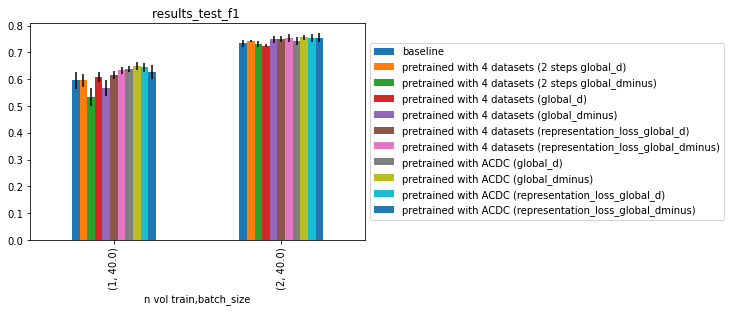

In [452]:
save_directory = './trained_models/ACDC/'

pretrainings = ['baseline',
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (2 steps global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)',
                'pretrained with ACDC (representation_loss_global_d)',
                'pretrained with ACDC (representation_loss_global_dminus)',
                
               ]
batch_sizes  = [40]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)
results_test_f1

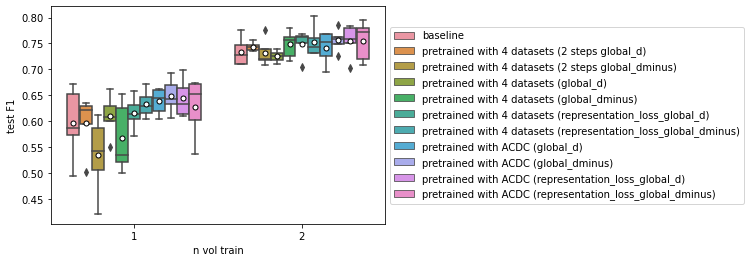

In [453]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

### Taking a closer look per label

mean  \
n vol train batch_size label model                                            
1           40         LV    baseline                              0.734495   
                             pretrained with ACDC (global_d)       0.760070   
                             pretrained with ACDC (global_dminus)  0.789894   
                       Myo   baseline                              0.592685   
                             pretrained with ACDC (global_d)       0.610385   
                             pretrained with ACDC (global_dminus)  0.633265   
                       RV    baseline                              0.459514   
                             pretrained with ACDC (global_d)       0.543554   
                             pretrained with ACDC (global_dminus)  0.523803   

                                                                   double_std  \
n vol train batch_size label model                                              
1           40         LV    baseline                                0.168020   
                             pretrained with ACDC (global_d)         0.108281   
                             pretrained with ACDC (global_dminus)    0.096087   
                       Myo   baseline                                0.097640   
                             pretrained with ACDC (global_d)         0.059932   
                             pretrained with ACDC (global_dminus)    0.066423   
                       RV    baseline                                0.139578   
                             pretrained with ACDC (global_d)         0.220911   
                             pretrained with ACDC (global_dminus)    0.212225   

                                                                        sem  
n vol train batch_size label model                                           
1           40         LV    baseline                              0.042005  
                             pretrained with ACDC (global_d)       0.027070  
                             pretrained with ACDC (global_dminus)  0.024022  
                       Myo   baseline                              0.024410  
                             pretrained with ACDC (global_d)       0.014983  
                             pretrained with ACDC (global_dminus)  0.016606  
                       RV    baseline                              0.034895  
                             pretrained with ACDC (global_d)       0.055228  
                             pretrained with ACDC (global_dminus)  0.053056

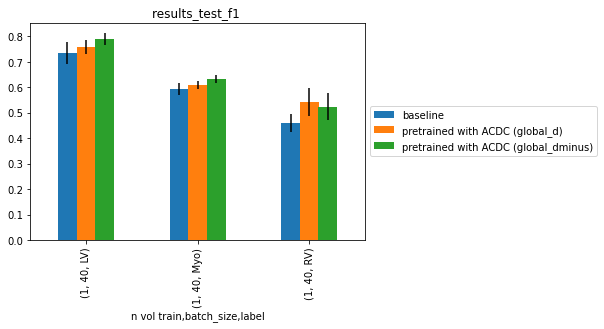

In [454]:
save_directory = './trained_models/ACDC/'
pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)']
batch_sizes  = [40]
n_trains = [1]

results_test_f1, results= plot_results_per_label(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1')
results_test_f1

# Results CIMAS (heart)

### Batch size comparaison

mean  double_std       sem
n vol train batch_size model                                   
1           16.0       baseline  0.479673    0.307015  0.076754
            40.0       baseline  0.510202    0.361107  0.090277
            64.0       baseline  0.538828    0.363157  0.090789
2           16.0       baseline  0.549155    0.211977  0.052994
            40.0       baseline  0.643661    0.189425  0.047356
            64.0       baseline  0.659494    0.163079  0.040770

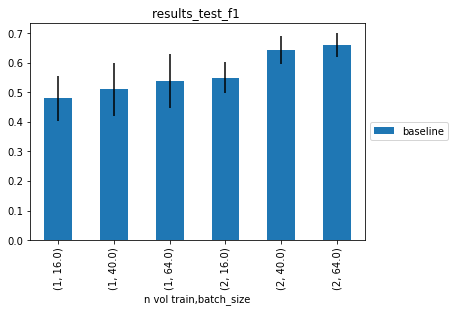

In [458]:
save_directory = './trained_models/CIMAS/'
pretrainings = ['baseline']
batch_sizes  = [16, 40, 64]
runs = ['0', '1', '2', '3', '4']
n_trains = [1, 2]
results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

mean  \
n vol train batch_size model                                            
1           16.0       baseline                              0.479673   
                       pretrained with ACDC (global_d)       0.442383   
                       pretrained with ACDC (global_dminus)  0.473675   
            40.0       baseline                              0.510202   
                       pretrained with ACDC (global_d)       0.538509   
                       pretrained with ACDC (global_dminus)  0.495083   
            64.0       baseline                              0.538828   
                       pretrained with ACDC (global_d)       0.553634   
                       pretrained with ACDC (global_dminus)  0.562549   
2           16.0       baseline                              0.549155   
                       pretrained with ACDC (global_d)       0.552300   
                       pretrained with ACDC (global_dminus)  0.562599   
            40.0       baseline                              0.643661   
                       pretrained with ACDC (global_d)       0.615816   
                       pretrained with ACDC (global_dminus)  0.642517   
            64.0       baseline                              0.659494   
                       pretrained with ACDC (global_d)       0.676726   
                       pretrained with ACDC (global_dminus)  0.627867   

                                                             double_std  \
n vol train batch_size model                                              
1           16.0       baseline                                0.307015   
                       pretrained with ACDC (global_d)         0.350096   
                       pretrained with ACDC (global_dminus)    0.314150   
            40.0       baseline                                0.361107   
                       pretrained with ACDC (global_d)         0.408664   
                       pretrained with ACDC (global_dminus)    0.389306   
            64.0       baseline                                0.363157   
                       pretrained with ACDC (global_d)         0.373493   
                       pretrained with ACDC (global_dminus)    0.408545   
2           16.0       baseline                                0.211977   
                       pretrained with ACDC (global_d)         0.089798   
                       pretrained with ACDC (global_dminus)    0.153509   
            40.0       baseline                                0.189425   
                       pretrained with ACDC (global_d)         0.138135   
                       pretrained with ACDC (global_dminus)    0.139714   
            64.0       baseline                                0.163079   
                       pretrained with ACDC (global_d)         0.162548   
                       pretrained with ACDC (global_dminus)    0.216544   

                                                                  sem  
n vol train batch_size model                                           
1           16.0       baseline                              0.076754  
                       pretrained with ACDC (global_d)       0.087524  
                       pretrained with ACDC (global_dminus)  0.078538  
            40.0       baseline                              0.090277  
                       pretrained with ACDC (global_d)       0.102166  
                       pretrained with ACDC (global_dminus)  0.097326  
            64.0       baseline                              0.090789  
                       pretrained with ACDC (global_d)       0.093373  
                       pretrained with ACDC (global_dminus)  0.102136  
2           16.0       baseline                              0.052994  
                       pretrained with ACDC (global_d)       0.022450  
                       pretrained with ACDC (global_dminus)  0.038377  
            40.0       baseline                              0.047356  
                       

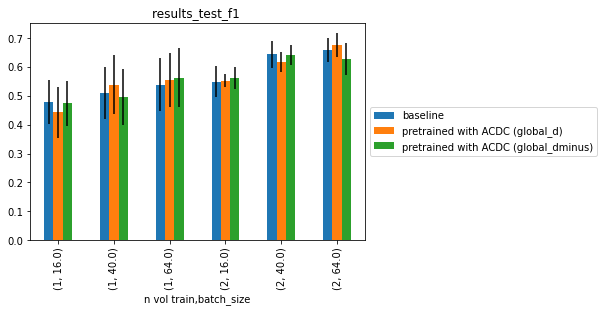

In [459]:
save_directory = './trained_models/CIMAS/'

pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)',
               ]

batch_sizes  = [16,40,64]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'CIMAS_results_f1', plot_loss = False)
results_test_f1

### Batch size = 64

mean  \
n vol train batch_size model                                            
1           64.0       baseline                              0.538828   
                       pretrained with ACDC (global_d)       0.553634   
                       pretrained with ACDC (global_dminus)  0.562549   
2           64.0       baseline                              0.659494   
                       pretrained with ACDC (global_d)       0.676726   
                       pretrained with ACDC (global_dminus)  0.627867   

                                                             double_std  \
n vol train batch_size model                                              
1           64.0       baseline                                0.363157   
                       pretrained with ACDC (global_d)         0.373493   
                       pretrained with ACDC (global_dminus)    0.408545   
2           64.0       baseline                                0.163079   
                       pretrained with ACDC (global_d)         0.162548   
                       pretrained with ACDC (global_dminus)    0.216544   

                                                                  sem  
n vol train batch_size model                                           
1           64.0       baseline                              0.090789  
                       pretrained with ACDC (global_d)       0.093373  
                       pretrained with ACDC (global_dminus)  0.102136  
2           64.0       baseline                              0.040770  
                       pretrained with ACDC (global_d)       0.040637  
                       pretrained with ACDC (global_dminus)  0.054136

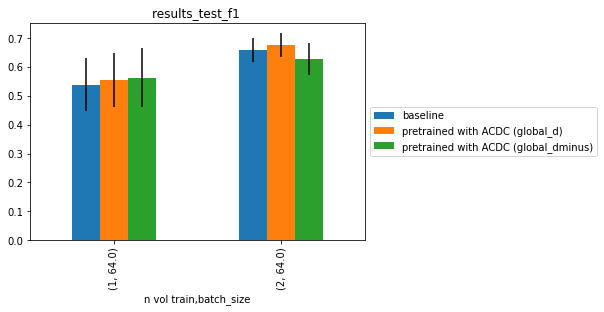

In [460]:
save_directory = './trained_models/CIMAS/'


pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)',
                #'pretrained with ACDC (representation_loss_global_d)',
                #'pretrained with ACDC (representation_loss_global_dminus)',
               ]

batch_sizes  = [64]


results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'CIMAS_results_f1', plot_loss = False)
results_test_f1

mean  \
n vol train batch_size label model                                            
1           64         LV    baseline                              0.417921   
                             pretrained with ACDC (global_d)       0.401108   
                             pretrained with ACDC (global_dminus)  0.441728   
                       Myo   baseline                              0.566668   
                             pretrained with ACDC (global_d)       0.588930   
                             pretrained with ACDC (global_dminus)  0.584811   
                       RV    baseline                              0.631896   
                             pretrained with ACDC (global_d)       0.670862   
                             pretrained with ACDC (global_dminus)  0.661108   
2           64         LV    baseline                              0.551072   
                             pretrained with ACDC (global_d)       0.588553   
                             pretrained with ACDC (global_dminus)  0.494274   
                       Myo   baseline                              0.680045   
                             pretrained with ACDC (global_d)       0.682459   
                             pretrained with ACDC (global_dminus)  0.668688   
                       RV    baseline                              0.747366   
                             pretrained with ACDC (global_d)       0.759168   
                             pretrained with ACDC (global_dminus)  0.720640   

                                                                   double_std  \
n vol train batch_size label model                                              
1           64         LV    baseline                                0.473290   
                             pretrained with ACDC (global_d)         0.399623   
                             pretrained with ACDC (global_dminus)    0.446943   
                       Myo   baseline                                0.284160   
                             pretrained with ACDC (global_d)         0.296198   
                             pretrained with ACDC (global_dminus)    0.306135   
                       RV    baseline                                0.347695   
                             pretrained with ACDC (global_d)         0.433573   
                             pretrained with ACDC (global_dminus)    0.479005   
2           64         LV    baseline                                0.225917   
                             pretrained with ACDC (global_d)         0.214368   
                             pretrained with ACDC (global_dminus)    0.501411   
                       Myo   baseline                                0.107943   
                             pretrained with ACDC (global_d)         0.121623   
                             pretrained with ACDC (global_dminus)    0.101601   
                       RV    baseline                                0.164524   
                             pretrained with ACDC (global_d)         0.155801   
                             pretrained with ACDC (global_dminus)    0.115308   

                                                                        sem  
n vol train batch_size label model                                           
1           64         LV    baseline                              0.118323  
                             pretrained with ACDC (global_d)       0.099906  
                             pretrained with ACDC (global_dminus)  0.111736  
                       Myo   baseline                              0.071040  
                             pretrained with ACDC (global_d)       0.074050  
                             pretrained with ACDC (global_dminus)  0.076534  
                       RV    baseline                              0.086924  
                             pretrained with ACDC (global_d)       0.108393  
                             pretrained with ACDC (global_dminus)  0.119751  
2          

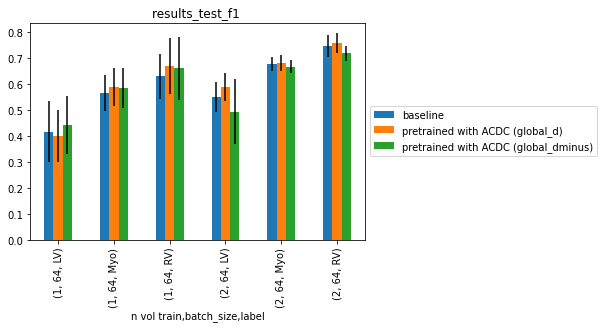

In [463]:
save_directory = './trained_models/CIMAS/'
pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)']
batch_sizes  = [64]
n_trains = [1, 2]

results_test_f1, results= plot_results_per_label(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1')
results_test_f1

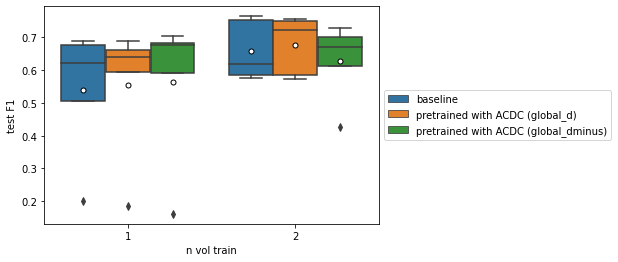

In [464]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'CIMAS_results_f1', plot_loss = False)

### Batch size = 40

mean  \
n vol train batch_size model                                                          
1           40.0       baseline                                            0.510202   
                       pretrained with ACDC (global_d)                     0.538509   
                       pretrained with ACDC (global_dminus)                0.495083   
                       pretrained with ACDC (representation_loss_globa...  0.530479   
                       pretrained with ACDC (representation_loss_globa...  0.525524   
2           40.0       baseline                                            0.643661   
                       pretrained with ACDC (global_d)                     0.615816   
                       pretrained with ACDC (global_dminus)                0.642517   
                       pretrained with ACDC (representation_loss_globa...  0.654189   
                       pretrained with ACDC (representation_loss_globa...  0.624885   

                                                                           double_std  \
n vol train batch_size model                                                            
1           40.0       baseline                                              0.361107   
                       pretrained with ACDC (global_d)                       0.408664   
                       pretrained with ACDC (global_dminus)                  0.389306   
                       pretrained with ACDC (representation_loss_globa...    0.457362   
                       pretrained with ACDC (representation_loss_globa...    0.370826   
2           40.0       baseline                                              0.189425   
                       pretrained with ACDC (global_d)                       0.138135   
                       pretrained with ACDC (global_dminus)                  0.139714   
                       pretrained with ACDC (representation_loss_globa...    0.158749   
                       pretrained with ACDC (representation_loss_globa...    0.183953   

                                                                                sem  
n vol train batch_size model                                                         
1           40.0       baseline                                            0.090277  
                       pretrained with ACDC (global_d)                     0.102166  
                       pretrained with ACDC (global_dminus)                0.097326  
                       pretrained with ACDC (representation_loss_globa...  0.114341  
                       pretrained with ACDC (representation_loss_globa...  0.092706  
2           40.0       baseline                                            0.047356  
                       pretrained with ACDC (global_d)                     0.034534  
                       pretrained with ACDC (global_dminus)                0.034928  
                       pretrained with ACDC (representation_loss_globa...  0.039687  
                       pretrained with ACDC (representation_loss_globa...  0.045988

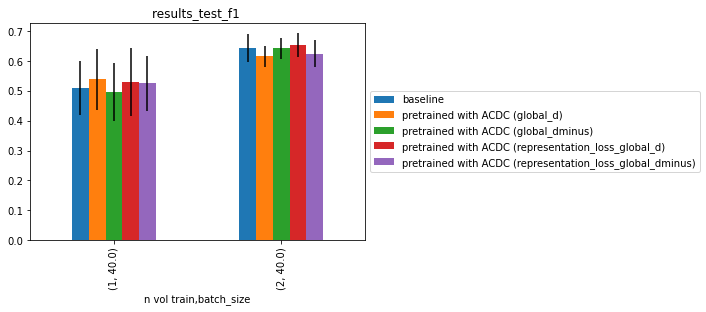

In [465]:
save_directory = './trained_models/CIMAS/'


pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)',
                'pretrained with ACDC (representation_loss_global_d)',
                'pretrained with ACDC (representation_loss_global_dminus)',
               ]

batch_sizes  = [40]


results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'CIMAS_results_f1', plot_loss = False)
results_test_f1

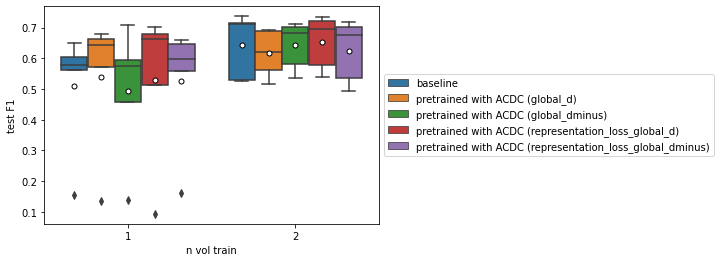

In [441]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'CIMAS_results_f1', plot_loss = False)

# Results MMWHS (heart)

# Results Abide (brain)

### Batch size comparaison

mean  double_std       sem
n vol train batch_size model                                   
1           16.0       baseline  0.255852    0.003221  0.001139
            40.0       baseline  0.328586    0.003113  0.001101
            64.0       baseline  0.365002    0.043889  0.015517
2           16.0       baseline  0.261199    0.003809  0.001347
            40.0       baseline  0.340362    0.000265  0.000094
            64.0       baseline  0.405328    0.012615  0.004460

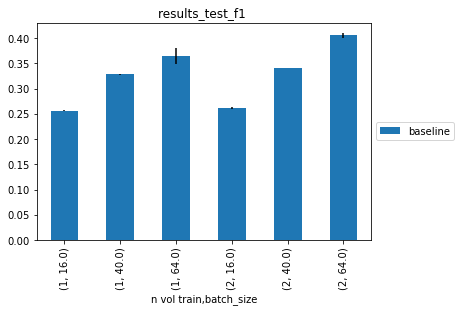

In [488]:
save_directory = './trained_models/max_epochs/Abide/'
runs = ['0','1', '2']
pretrainings = ['baseline']
batch_sizes  = [16, 40, 64]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'Abide_batch_size_results_f1', plot_loss = False)
results_test_f1

### Pretrained with Abide, Abide fine-tuning

mean  \
n vol train batch_size model                                                          
1           64.0       baseline                                            0.331548   
                       pretrained with Abide (global_d)                    0.377235   
                       pretrained with Abide (global_dminus)               0.377985   
                       pretrained with Abide (representation_loss_glob...  0.383089   
                       pretrained with Abide (representation_loss_glob...  0.383562   
2           64.0       baseline                                            0.401783   
                       pretrained with Abide (global_d)                    0.407680   
                       pretrained with Abide (global_dminus)               0.410523   
                       pretrained with Abide (representation_loss_glob...  0.415488   
                       pretrained with Abide (representation_loss_glob...  0.415844   

                                                                           double_std  \
n vol train batch_size model                                                            
1           64.0       baseline                                              0.121963   
                       pretrained with Abide (global_d)                      0.019604   
                       pretrained with Abide (global_dminus)                 0.022873   
                       pretrained with Abide (representation_loss_glob...    0.014823   
                       pretrained with Abide (representation_loss_glob...    0.015936   
2           64.0       baseline                                              0.016438   
                       pretrained with Abide (global_d)                      0.011391   
                       pretrained with Abide (global_dminus)                 0.013297   
                       pretrained with Abide (representation_loss_glob...    0.003526   
                       pretrained with Abide (representation_loss_glob...    0.003672   

                                                                                sem  
n vol train batch_size model                                                         
1           64.0       baseline                                            0.035208  
                       pretrained with Abide (global_d)                    0.005659  
                       pretrained with Abide (global_dminus)               0.006603  
                       pretrained with Abide (representation_loss_glob...  0.004279  
                       pretrained with Abide (representation_loss_glob...  0.004600  
2           64.0       baseline                                            0.004745  
                       pretrained with Abide (global_d)                    0.003288  
                       pretrained with Abide (global_dminus)               0.003839  
                       pretrained with Abide (representation_loss_glob...  0.001018  
                       pretrained with Abide (representation_loss_glob...  0.001060

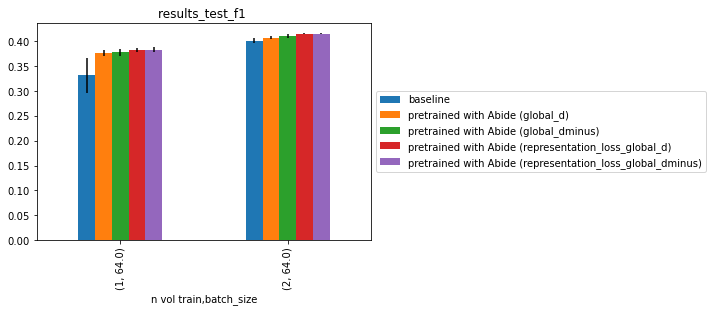

In [518]:
save_directory = './trained_models/max_epochs/Abide/'
runs = ['0', '1', '2', '4']
pretrainings = ['baseline',
                'pretrained with Abide (global_d)',
                'pretrained with Abide (global_dminus)',
                'pretrained with Abide (representation_loss_global_d)',
                'pretrained with Abide (representation_loss_global_dminus)',
                
               ]
n_trains = [1,2]
batch_sizes  = [64]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_results_f1', plot_loss = False)
results_test_f1

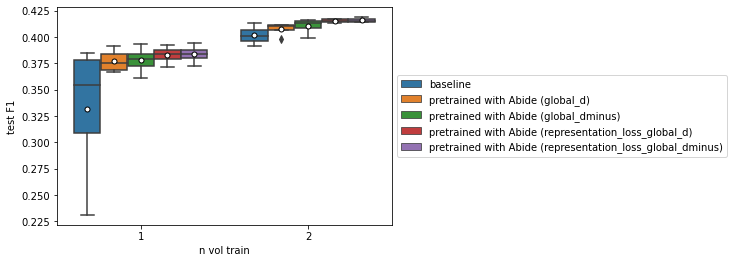

In [519]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_results_f1', plot_loss = False)

## tking a closer look per label

(                                                          F1 label             \
                                                               mean double_std   
 label model                                                                     
 1     baseline                                            0.466534   0.003638   
       pretrained with Abide (representation_loss_glob...  0.467364   0.002888   
       pretrained with Abide (representation_loss_glob...  0.467692   0.002535   
 10    baseline                                            0.298319   0.345376   
       pretrained with Abide (representation_loss_glob...  0.410062   0.027243   
       pretrained with Abide (representation_loss_glob...  0.416087   0.015108   
 11    baseline                                            0.151411   0.240227   
       pretrained with Abide (representation_loss_glob...  0.316976   0.032581   
       pretrained with Abide (representation_loss_glob...  0.305142   0.065483   
 12    baseline 

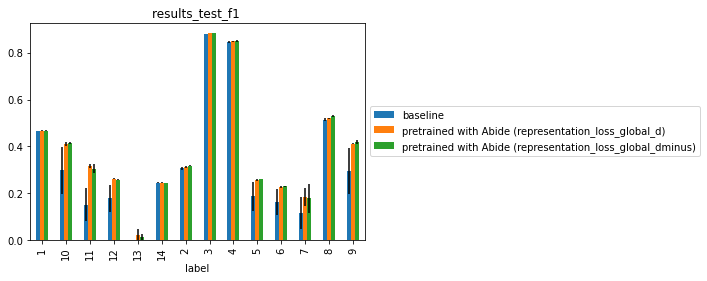

In [520]:
pretrainings = ['baseline',
                'pretrained with Abide (representation_loss_global_d)',
                'pretrained with Abide (representation_loss_global_dminus)'
               ]
n_trains = [1]
plot_results_per_label_Abide(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, 'Abide_results_f1')

### Pretrained with 4 datasets, Abide fine-tuning (Abide not seen in pre-training)

mean  \
n vol train batch_size model                                                          
1           64.0       baseline                                            0.331548   
                       pretrained with 4 datasets (2 steps global_d)       0.387676   
                       pretrained with 4 datasets (2 steps global_dminus)  0.383453   
                       pretrained with 4 datasets (global_d)               0.385026   
                       pretrained with 4 datasets (global_dminus)          0.394460   
                       pretrained with 4 datasets (representation_loss...  0.383306   
                       pretrained with 4 datasets (representation_loss...  0.389653   
2           64.0       baseline                                            0.401783   
                       pretrained with 4 datasets (2 steps global_d)       0.411292   
                       pretrained with 4 datasets (2 steps global_dminus)  0.412716   
                       pretrained with 4 datasets (global_d)               0.414222   
                       pretrained with 4 datasets (global_dminus)          0.416813   
                       pretrained with 4 datasets (representation_loss...  0.416910   
                       pretrained with 4 datasets (representation_loss...  0.414833   

                                                                           double_std  \
n vol train batch_size model                                                            
1           64.0       baseline                                              0.121963   
                       pretrained with 4 datasets (2 steps global_d)         0.020634   
                       pretrained with 4 datasets (2 steps global_dminus)    0.004114   
                       pretrained with 4 datasets (global_d)                 0.014877   
                       pretrained with 4 datasets (global_dminus)            0.010652   
                       pretrained with 4 datasets (representation_loss...    0.021934   
                       pretrained with 4 datasets (representation_loss...    0.007245   
2           64.0       baseline                                              0.016438   
                       pretrained with 4 datasets (2 steps global_d)         0.011205   
                       pretrained with 4 datasets (2 steps global_dminus)    0.006858   
                       pretrained with 4 datasets (global_d)                 0.006638   
                       pretrained with 4 datasets (global_dminus)            0.005224   
                       pretrained with 4 datasets (representation_loss...    0.000927   
                       pretrained with 4 datasets (representation_loss...    0.001855   

                                                                                sem  
n vol train batch_size model                                                         
1           64.0       baseline                                            0.035208  
                       pretrained with 4 datasets (2 steps global_d)       0.005957  
                       pretrained with 4 datasets (2 steps global_dminus)  0.001188  
                       pretrained with 4 datasets (global_d)               0.004295  
                       pretrained with 4 datasets (global_dminus)          0.003075  
                       pretrained with 4 datasets (representation_loss...  0.006332  
                       pretrained with 4 datasets (representation_loss...  0.002091  
2           64.0       baseline                                            0.004745  
                       pretrained with 4 datasets (2 steps global_d)       0.003235  
                       pretrained with 4 datasets (2 steps global_dminus)  0.001980  
                       pretrained with 4 datasets (global_d)               0.001916  
                       pretrained with 4 datasets (global_dminus)          0.001508  
                       pretrained with 4 datasets (repres

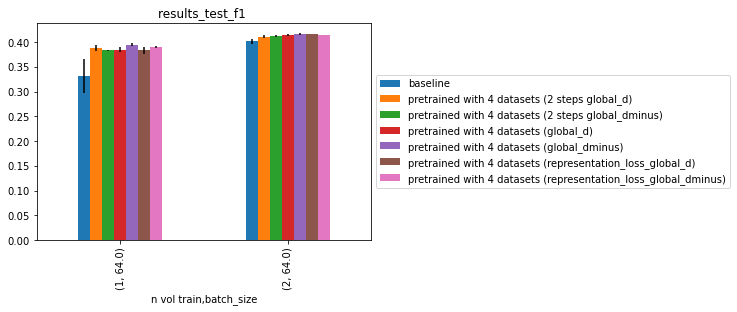

In [521]:
save_directory = './trained_models/max_epochs/Abide/'
pretrainings = ['baseline',
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (2 steps global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
                
               ]
n_trains = [1,2]
batch_sizes  = [64]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_results_f1', plot_loss = False)
results_test_f1

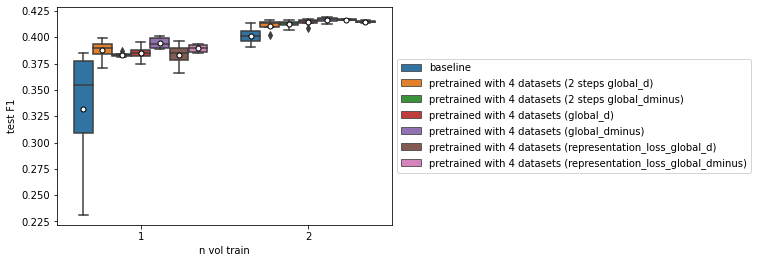

In [522]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_results_f1', plot_loss = False)

### All together, Abide fine-tuning

mean  \
n vol train batch_size model                                                  
1           64.0       baseline                                    0.331548   
                       pretrained with 4 datasets (global_d)       0.385026   
                       pretrained with 4 datasets (global_dminus)  0.394460   
                       pretrained with Abide (global_d)            0.377235   
                       pretrained with Abide (global_dminus)       0.377985   
2           64.0       baseline                                    0.401783   
                       pretrained with 4 datasets (global_d)       0.414222   
                       pretrained with 4 datasets (global_dminus)  0.416813   
                       pretrained with Abide (global_d)            0.407680   
                       pretrained with Abide (global_dminus)       0.410523   

                                                                   double_std  \
n vol train batch_size model                                                    
1           64.0       baseline                                      0.121963   
                       pretrained with 4 datasets (global_d)         0.014877   
                       pretrained with 4 datasets (global_dminus)    0.010652   
                       pretrained with Abide (global_d)              0.019604   
                       pretrained with Abide (global_dminus)         0.022873   
2           64.0       baseline                                      0.016438   
                       pretrained with 4 datasets (global_d)         0.006638   
                       pretrained with 4 datasets (global_dminus)    0.005224   
                       pretrained with Abide (global_d)              0.011391   
                       pretrained with Abide (global_dminus)         0.013297   

                                                                        sem  
n vol train batch_size model                                                 
1           64.0       baseline                                    0.035208  
                       pretrained with 4 datasets (global_d)       0.004295  
                       pretrained with 4 datasets (global_dminus)  0.003075  
                       pretrained with Abide (global_d)            0.005659  
                       pretrained with Abide (global_dminus)       0.006603  
2           64.0       baseline                                    0.004745  
                       pretrained with 4 datasets (global_d)       0.001916  
                       pretrained with 4 datasets (global_dminus)  0.001508  
                       pretrained with Abide (global_d)            0.003288  
                       pretrained with Abide (global_dminus)       0.003839

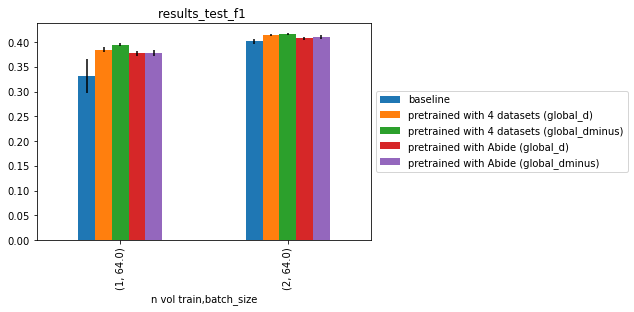

In [523]:
save_directory = './trained_models/max_epochs/Abide/'
pretrainings = ['baseline',
                #'pretrained with 4 datasets (2 steps global_d)',
                #'pretrained with 4 datasets (2 steps global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (global_dminus)',
                #'pretrained with 4 datasets (representation_loss_global_d)',
                #'pretrained with 4 datasets (representation_loss_global_dminus)',
                'pretrained with Abide (global_d)',
                'pretrained with Abide (global_dminus)',
                #'pretrained with Abide (representation_loss_global_d)',
                #'pretrained with Abide (representation_loss_global_dminus)',
                
               ]
n_trains = [1, 2]
batch_sizes  = [64]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_results_f1', plot_loss = False)
results_test_f1

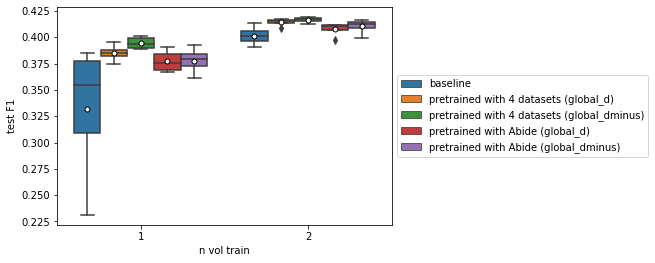

In [524]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_results_f1', plot_loss = False)

In [525]:
def plot_results_per_label_Abide(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file) :
    results = pd.DataFrame(columns = ["F1 label", "label", "n vol train", "batch_size", "model"])
    labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'] 
    
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        for i,label in enumerate(labels) :
                            results_BN["F1 label"] = results_BN['f1_arr'][0][i]
                            results_BN["label"] = label
                            #if label  in ['13', '11', '7', '2', '12']:
                            results=results.append(results_BN)
    
    results_mean = results.groupby(["label", "model"]).agg([np.mean, double_std, sp.sem])
    results_test_f1 = results_mean['F1 label']
    
    results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem").get_figure()
    
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return results_mean, results_test_f1

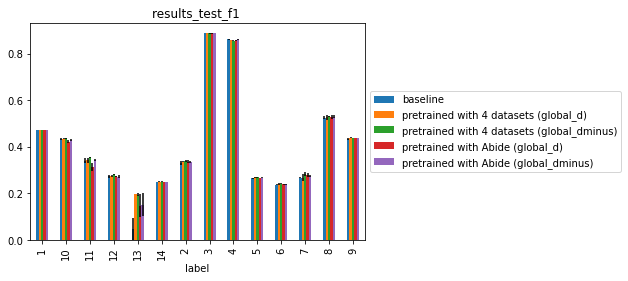

In [526]:
n_trains = [2]
results_mean, results_label = plot_results_per_label_Abide(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, 'Abide_results_f1')

In [527]:
(results_label.max(level = 0) - results_label.xs('baseline', level = 1)).sort_values('mean', ascending = False)

,mean,double_std,sem
label,,,
13,0.148444,0.012146,0.003506
7,0.016924,0.037708,0.010885
11,0.015345,0.018531,0.005349
12,0.009258,0.000146,0.000042
2,0.007959,0.000000,0.000000
9,0.005367,0.000000,0.000000
8,0.005138,0.010221,0.002951
6,0.004844,0.002479,0.000716
5,0.003420,0.000000,0.000000
